In [1]:
import tensorflow as tf
import numpy as np
import re
import unicodedata
from sklearn.model_selection import train_test_split
import os
import time
#tf.enable_eager_execution()

In [2]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', 
                                      origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [3]:
# convert unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [4]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return word_pairs

In [6]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
          self.vocab.update(phrase.split(' '))
    
        self.vocab = sorted(self.vocab)
    
        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
          self.word2idx[word] = index + 1
    
        for word, index in self.word2idx.items():
          self.idx2word[index] = word

In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)
    
    # index language using the class defined above    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,
                                                                maxlen=max_length_inp,
                                                                padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,
                                                                 maxlen=max_length_tar,
                                                                 padding='post')
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [9]:
# Try experimenting with the size of that dataset
num_examples = 3000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [10]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(2400, 2400, 600, 600)

In [11]:
# Create a tf.data dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.shuffle(10)
dataset = dataset.map(lambda x,y:(x,y, tf.size(x), tf.size(y)))
dataset = dataset.batch(BATCH_SIZE)

In [12]:
embeddings_encoder = tf.get_variable('embedding_enc',shape=(vocab_inp_size,embedding_dim), 
                             initializer=tf.random_uniform_initializer)
embeddings_decoder = tf.get_variable('embedding_dec',shape=(vocab_tar_size,embedding_dim), 
                             initializer=tf.random_uniform_initializer)

In [13]:
def encode(encode_input_emb):
    with tf.variable_scope('encode',reuse=tf.AUTO_REUSE):
        encoder_cell= tf.nn.rnn_cell.BasicLSTMCell(units)
        encoder_cell = tf.nn.rnn_cell.DropoutWrapper(encoder_cell,input_keep_prob=1, output_keep_prob=0.5)
        enc_out, enc_state = tf.nn.dynamic_rnn(encoder_cell,encode_input_emb,dtype=tf.float32)
    return enc_state

In [14]:
def decode(decode_input_emb, initiale_state):
    with tf.variable_scope('decode',reuse=tf.AUTO_REUSE):
        
        decoder_cell= tf.nn.rnn_cell.BasicLSTMCell(units)
        decoder_cell= tf.nn.rnn_cell.DropoutWrapper(decoder_cell,input_keep_prob=1,output_keep_prob=0.5)
        dec_out, dec_state = tf.nn.dynamic_rnn(decoder_cell,decode_input_emb,
                                               initial_state=initiale_state,dtype=tf.float32)
        dec_output = tf.layers.dense(dec_out,vocab_tar_size)
    return dec_output

In [15]:
def seq2seq(encode_input_emb,decode_input_emb,enc_size):
    enc_state = encode(tf.nn.embedding_lookup(embeddings_encoder,enc_inp))
    dec_output = decode(tf.nn.embedding_lookup(embeddings_decoder,decode_input_emb),enc_state)
    print('final',tf.shape(dec_output))
    return dec_output
    

In [16]:
def loss_function(dec_inp,logit):
    with tf.variable_scope('loss',reuse=tf.AUTO_REUSE):
        mask = 1 - np.equal(enc_inp, 0)
        #print('shape',tf.shape(pred))
        #print('target', enc_inp.shape)
        #logit = seq2seq(enc_inp,dec_inp,enc_size)
        loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=dec_inp, logits=logit)
        loss1_= loss_*mask
    return tf.reduce_mean(loss1_)
    

In [17]:
iterator = dataset.make_initializable_iterator()
enc_inp, dec_inp ,enc_size, dec_size = iterator.get_next()

with tf.variable_scope('adam1', reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    #loss1 = loss_function(dec_inp, logit)
    #loss_op = optimizer.minimize(loss1)

In [18]:
import matplotlib.pyplot as plt
% matplotlib inline

final Tensor("Shape:0", shape=(3,), dtype=int32)
loss after 0 epoch is 2.406315326690674
accuracy after 0 epoch is 0.5703125
loss after 1 epoch is 2.109083652496338
accuracy after 1 epoch is 0.64453125
loss after 2 epoch is 1.890817403793335
accuracy after 2 epoch is 0.6953125
loss after 3 epoch is 1.951646327972412
accuracy after 3 epoch is 0.62890625
loss after 4 epoch is 1.6667754650115967
accuracy after 4 epoch is 0.75390625
loss after 5 epoch is 1.6484253406524658
accuracy after 5 epoch is 0.72265625
loss after 6 epoch is 1.5828717947006226
accuracy after 6 epoch is 0.72265625
loss after 7 epoch is 1.484752893447876
accuracy after 7 epoch is 0.75390625
loss after 8 epoch is 1.3398027420043945
accuracy after 8 epoch is 0.7578125
loss after 9 epoch is 1.4076335430145264
accuracy after 9 epoch is 0.7890625
loss after 10 epoch is 1.3415203094482422
accuracy after 10 epoch is 0.76953125
loss after 11 epoch is 1.208390235900879
accuracy after 11 epoch is 0.82421875
loss after 12 epoch i

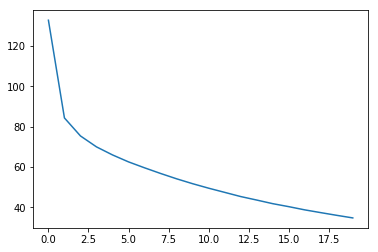

In [19]:
logit = seq2seq(enc_inp,dec_inp,enc_size)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logit,axis=-1), tf.cast(dec_inp,tf.int64)),tf.float32))
#test_val = tf.argmax(logit,axis=1)
#test_valN1 = tf.argmax(logit,axis=-1)
loss1 = loss_function(dec_inp, logit)
gradients = optimizer.compute_gradients(loss1)
capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
train_op = optimizer.apply_gradients(capped_gradients)
#loss_op = optimizer.minimize(loss1)
losses = []
#last_val = None
#last_val_axisN1 = None
#last_logit = None
with tf.Session() as sess:
    sess.run([tf.global_variables_initializer()])
    for epoc in range(20):
        #train_op = seq2seq(enc_inp,dec_inp,enc_size )
        #print(enc_inp.shape)
        #dec_output = sess.run([train_op])
        #print(tf.sqnp.array(dec_output))
        #print('Shape ',tf.convert_to_tensor(np.array(dec_output)))
        #dec_output = np.array(dec_output)
        #print(tf.squeeze(dec_output))
        #print(tf.shape(tf.nn.embedding_lookup(embeddings_decoder,dec_inp)).eval())
        sess.run(iterator.initializer)
        total_loss=0
        try:
            while True:
                #print(dec_inp.eval())
                _,loss_val,acc = sess.run([train_op,loss1,accuracy])
                #print(testval.shape)
                total_loss +=loss_val
            
        except tf.errors.OutOfRangeError:
            pass
        print('loss after {0} epoch is {1}'.format(epoc,loss_val))
        print('accuracy after {0} epoch is {1}'.format(epoc,acc))
        #print(testval)
        #last_val = testval
        #last_val_axisN1 = testvalN
        #last_logit = logitlast
        losses.append(total_loss)
plt.plot(losses)

In [ ]:
last_val[0]

In [ ]:
last_val_axisN1[0]

In [ ]:
np.argmax(last_logit[0,2,:])

In [ ]:
np.argmax(last_logit,axis=2)

In [ ]:
vocab_tar_size

In [ ]:
for (batch,(enc_inp, dec_inp ,enc_size, dec_size)) in enumerate(dataset):
    #train_op = seq2seq(enc_inp,dec_inp,enc_size )
   
    #print('predictions',train_op.shape)
    #print('real',dec_inp.shape)
    #mask = 1-np.equal(train_op, 0)
    #loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=dec_inp,logits=np.array(train_op))*mask
    with tf.GradientTape() as tape:
        
    variables = tf.trainable_variables()
    
    loss_= loss_function(dec_inp, dec_inp,enc_size)
    var_grad = optimizer.compute_gradients(loss_,variables)
    optimizer.apply_gradients(var_grad)
    print(loss_)

In [ ]:
v[:,:-1]

In [ ]:
v[:,1:]

In [ ]:
import tensorflow as tf
T=tf.constant([[[10,11,12],[13,14,15]],
[[16,17,18],[19,20,21]],
[[22,23,24],[25,26,27]]])
sess=tf.InteractiveSession()


In [ ]:
S=tf.slice(T,[0,1,1],[1,1,2])
print(S.eval())

In [ ]:
T.eval()

In [ ]:
a = np.array([[[10,11,12],[13,14,15]],
[[16,17,18],[19,20,21]],
[[22,23,24],[25,26,27]],
             [[0,0,0],[0,0,0]]])

In [ ]:
a.shape

In [ ]:
1-np.equal(a,0)

In [ ]:
a*(1-np.equal(a,0))